In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
import statsmodels.api as sm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from datetime import datetime, timedelta
import requests
import time
import ollama
from tqdm import tqdm

In [16]:
start_date = "2015-01-01"
end_date="2025-11-13"

tsla = yf.download("TSLA", start=start_date, end=end_date)

tsla = tsla.droplevel(level=1, axis=1)
tsla_org = tsla.asfreq('B')
tsla = tsla_org.interpolate(method='time')
tsla.tail()

C:\Users\USER\AppData\Local\Temp\ipykernel_11656\245185109.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download("TSLA", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-11-06,445.910004,467.450012,435.089996,461.959991,109622900.0
2025-11-07,429.519989,439.359985,421.880005,437.920013,103471500.0
2025-11-10,445.230011,449.670013,433.359985,439.600006,76515900.0
2025-11-11,439.619995,442.489990,432.359985,439.399994,60533200.0
2025-11-12,430.600006,442.329987,426.559998,442.149994,58513500.0


In [23]:
df_news = pd.read_csv("financial_news.csv")

df_news['dt'] = pd.to_datetime(df_news['dt']).dt.date
df_news = df_news.sort_values(by='dt')
df_news.head()

,Unnamed: 0,dt,body
14,14,2015-01-02,Tesla Motors Club Hong Kong rallies it up with...
13,13,2015-01-05,We always look forward to December sales when ...
12,12,2015-01-07,Detroit Electric released a few of the latest ...
11,11,2015-01-12,The Chevrolet Volt has long been considered th...
10,10,2015-01-13,"On Monday, General Motors took the cover off t..."


In [17]:
def train_test_split_series(series: pd.Series, test_size: int = 60):
    train = series.iloc[:-test_size]
    test  = series.iloc[-test_size:]
    return train, test

tsla_price = tsla['Close']
test_ratio = 0.2
test_size = int(len(tsla) * test_ratio)
train_d, test_d = train_test_split_series(tsla['Close'], test_size=test_size)
len(train_d), len(test_d)

(2268, 566)

In [ ]:
test_d #starts from 2023-09-13

Date
2023-09-13    271.299988
2023-09-14    276.040009
2023-09-15    274.390015
2023-09-18    265.279999
2023-09-19    266.500000
                 ...    
2025-11-06    445.910004
2025-11-07    429.519989
2025-11-10    445.230011
2025-11-11    439.619995
2025-11-12    430.600006
Freq: B, Name: Close, Length: 566, dtype: float64

In [92]:
LOOKBACK = 15  
START_DATE = '2023-09-13'
END_DATE = '2024-11-13'
OLLAMA_MODEL = 'llama3:8b' 
N_SAMPLES = 1000
SAVE_FILE = "llm_pred.csv"  


def summarize_news(text):
    prompt = PROMPTS['summary'](text)
    resp = ollama.chat(
        model=OLLAMA_MODEL,
        messages=[
            {"role": "system", "content": "You are a concise financial news summarizer."},
            {"role": "user", "content": prompt},
        ],
    )
    return resp["message"]["content"].strip()

def fetch_news(date_str):
    news_on_day = list(df_news[df_news.dt == date_str.date()]['body'][:5].apply(summarize_news))
    return '\n============================================\n'.join(news_on_day) if news_on_day else "No relevant news found."

PROMPTS = {
    'P1': lambda symbol, window, hist: f"""Given this data: 
    Historical prices for {symbol} over the past {window} days: 
    {hist}
    Based on the historical prices and recent news, predict the price for {symbol} for the next day. 
    Provide your prediction as a single number e.g., 38500. Do not include any text other than the number.""",
    'P2': lambda symbol, window, hist, news: f"""Given this data: 
    Historical prices for {symbol} over the past {window} days: 
    {hist}
    Recent news headlines related to {symbol}: {news}
    Based on the historical prices and recent news, predict the price for {symbol} for the next day. 
    Provide your prediction as a single number e.g., 385.00. Do not include any text other than the number.""",
    'summary': lambda news: f"""
    You are given a financial text that consists of multiple sentences. You must summarize
    this text in only one short sentence. Text: {news}"
    """
}

def format_history(price_df, date):
    idx = price_df.index.get_loc(date)
    start_idx = max(0, idx - LOOKBACK)
    hist = price_df.iloc[start_idx:idx]

    ret = []
    for dt, row in hist.iterrows():
        date_str = dt.strftime("%Y-%m-%d")
        ret.append(f"{date_str}: {row['Close']:.2f}")
    return ", ".join(ret)

def generate_forecast(prompt, n_samples=50):  # Reduced for speed; paper uses 1000
    """Run LLM n_samples times, return median"""
    preds = []
    for _ in range(n_samples):
        resp = ollama.chat(model=OLLAMA_MODEL, messages=[
            {'role': 'system', 'content': 'You are a financial forecasting assistant.'},
            {'role': 'user', 'content': prompt}
        ])
        pred_str = resp['message']['content'].strip()
        try:
            pred = float(pred_str)
            preds.append(pred)
        except:
            pass
    return np.median(preds) if preds else np.nan

def date_range():
    for i in range(2268, len(tsla)):
        yield tsla.iloc[i].name

forecasts = []

for date in date_range():
    print("Analyzing", date)  
    hist = format_history(tsla, date)

    news_current = fetch_news(date)
    prompt_p2 = PROMPTS['P2']("TESLA", LOOKBACK, hist, news_current)
    # prompt_p1 = PROMPTS['P1']("TESLA", LOOKBACK, hist)
    pred_p2 = generate_forecast(prompt_p2)
    forecasts.append({"date": date,
                      "pred": pred_p2})

forecasts = pd.DataFrame(forecasts)
forecasts.head()
forecasts.to_csv(SAVE_FILE, index=False)

Analyzing 2023-09-13 00:00:00
Analyzing 2023-09-14 00:00:00
Analyzing 2023-09-15 00:00:00
Analyzing 2023-09-18 00:00:00
Analyzing 2023-09-19 00:00:00
Analyzing 2023-09-20 00:00:00
Analyzing 2023-09-21 00:00:00
Analyzing 2023-09-22 00:00:00
Analyzing 2023-09-25 00:00:00
Analyzing 2023-09-26 00:00:00
Analyzing 2023-09-27 00:00:00
Analyzing 2023-09-28 00:00:00
Analyzing 2023-09-29 00:00:00
Analyzing 2023-10-02 00:00:00
Analyzing 2023-10-03 00:00:00
Analyzing 2023-10-04 00:00:00
Analyzing 2023-10-05 00:00:00
Analyzing 2023-10-06 00:00:00
Analyzing 2023-10-09 00:00:00
Analyzing 2023-10-10 00:00:00
Analyzing 2023-10-11 00:00:00
Analyzing 2023-10-12 00:00:00
Analyzing 2023-10-13 00:00:00
Analyzing 2023-10-16 00:00:00
Analyzing 2023-10-17 00:00:00
Analyzing 2023-10-18 00:00:00
Analyzing 2023-10-19 00:00:00
Analyzing 2023-10-20 00:00:00
Analyzing 2023-10-23 00:00:00
Analyzing 2023-10-24 00:00:00
Analyzing 2023-10-25 00:00:00
Analyzing 2023-10-26 00:00:00
Analyzing 2023-10-27 00:00:00
Analyzing 

In [95]:
def metrics(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape}

forecasts = pd.read_csv("llm_pred.csv")
m = metrics(tsla.iloc[2268:]['Close'], forecasts['pred'])
print(m)

{'MAE': np.float64(11.55231899167118), 'RMSE': np.float64(15.63709846754339), 'MAPE(%)': np.float64(4.327791855798884)}


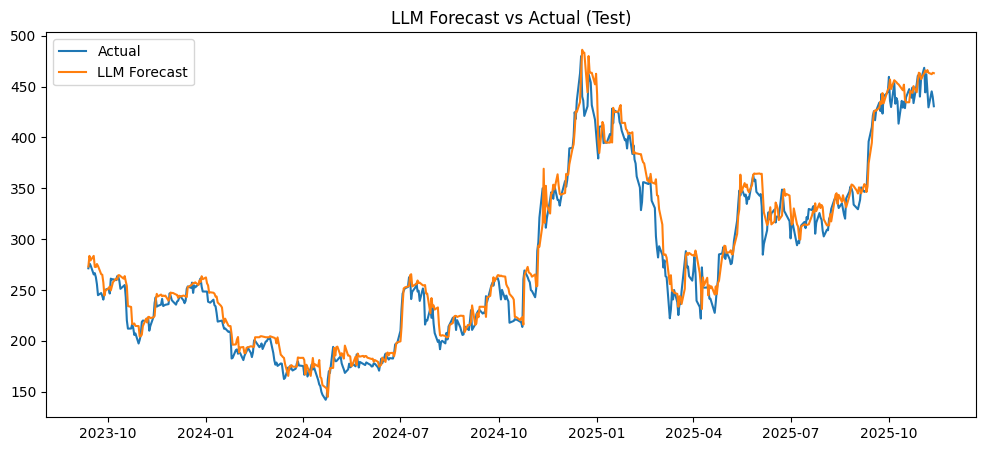

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(tsla.iloc[2268:].index, tsla[2268:]['Close'], label="Actual")
plt.plot(tsla.iloc[2268:].index, forecasts['pred'], label="LLM Forecast")
plt.title("LLM Forecast vs Actual (Test)")
plt.legend()
plt.show()
#performance
#{'MAE': np.float64(11.55231899167118), 'RMSE': np.float64(15.63709846754339), 'MAPE(%)': np.float64(4.327791855798884)}